# Setup
## Imports

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt
import json
import pandas as pd

from generative_social_choice.utils.helper_functions import get_base_dir_path
from generative_social_choice.slates.voting_utils import gini
from generative_social_choice.ratings.utility_matrix import extract_voter_utilities_from_info_csv
from generative_social_choice.utils.postprocessing import (
    plot_sorted_utility_distributions,
    plot_likert_category_clustered_bar_chart,
    scalar_utility_metrics,
    plot_candidate_distribution_stacked,
    
)


/Users/john/code/generative_social_choice/generative_social_choice/ratings/utility_matrix.py:117: SyntaxWarning: invalid escape sequence '\d'
  """


## Load data

In [4]:
from generative_social_choice.utils.helper_functions import get_results_paths

LABELLING_MODEL = "4o-mini"

baseline_result_dirs = get_results_paths(labelling_model=LABELLING_MODEL, baseline=True,  embedding_type="seed_statement")
baseline_result_dirs

{'utility_matrix_file': PosixPath('/Users/john/code/generative_social_choice/generative_social_choice/data/utility_matrix_results/baseline/4o-mini_for_labelling/baseline_utility_matrix.csv'),
 'statement_id_file': PosixPath('/Users/john/code/generative_social_choice/generative_social_choice/data/utility_matrix_results/baseline/4o-mini_for_labelling/baseline_utility_matrix_statements.csv'),
 'assignments': PosixPath('/Users/john/code/generative_social_choice/generative_social_choice/data/utility_matrix_results/baseline/4o-mini_for_labelling/baseline_assignments.json')}

In [9]:
# Baseline Assignments
baseline_assignments_file_path = baseline_result_dirs["assignments"]

with open(baseline_assignments_file_path, "r") as f:
    baseline_assignment_data = (json.load(f))

#baseline_assignment_data.keys()

# Create DataFrame with assignments and utilities
baseline_assignments = pd.DataFrame({
    'candidate_id': baseline_assignment_data['assignments'],
    'utility': baseline_assignment_data['utilities']
}, index=baseline_assignment_data['agent_ids'])
baseline_assignments.head()

,candidate_id,utility
generation1,s5,3.987445
generation2,s5,3.950370
generation3,s4,3.995421
generation4,s4,3.993168
generation5,s4,3.989752


In [11]:
# Re-assigning baseline statements using our voting algorithms
from generative_social_choice.scripts.compute_assignments import run as compute_assignments
from generative_social_choice.scripts.compute_assignments import VOTING_ALGORITHMS

assignment_dir = get_base_dir_path() / "data" / "demo_data" / "baseline-re-assignments"

for name, algo in VOTING_ALGORITHMS.items():
    compute_assignments(
        slate_size=5,
        voting_algotirhm=algo,
        utility_matrix_file=baseline_result_dirs["utility_matrix_file"],
        statement_id_file=baseline_result_dirs["statement_id_file"],
        assignment_file=assignment_dir / f"{name}.json",
        include_seed=True,
        verbose=False,
    )

In [12]:
algo_assignment_files = {
    path.stem: path for path in assignment_dir.glob("*.json")
}

utilities = pd.DataFrame(columns=algo_assignment_files.keys(), index=baseline_assignments.index)
utilities["Baseline"] = baseline_assignments["utility"]
# utilities["Baseline OpenAI Emb."] = df_bjr_with_openai_embeddings["utility"]
utilities.head(10)


,"Phragmen(marginal_previous, clear=True, redist=False)",greedy (p=1.5),"Phragmen(marginal_previous, clear=True, redist=True)",exact,lp (p=1.5),"Phragmen(marginal_slate, clear=False, redist=False)",exact (p=1.5),"Phragmen(marginal_slate, clear=True, redist=True)",greedy,"Phragmen(marginal_previous, clear=False, redist=True)","Phragmen(marginal_slate, clear=True, redist=False)",lp,"Phragmen(marginal_previous, clear=False, redist=False)","Phragmen(marginal_slate, clear=False, redist=True)",Baseline
generation1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.987445
generation2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.950370
generation3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.995421
generation4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.993168
generation5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.989752
generation6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.840453
generation7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.995174
generation8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.990619
generation9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.965117
generation10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.985305


In [14]:


algo_assignments = pd.DataFrame(columns=list(algo_assignment_files.keys()), index=baseline_assignments.index)

for algo_name, file_path in algo_assignment_files.items():
    with open(file_path, "r") as f:
        algo_assignment_data = (json.load(f))
        algo_utilities = pd.Series(algo_assignment_data['utilities'], index=algo_assignment_data['agent_ids'])
        utilities[algo_name] = algo_utilities
        cur_algo_assignments = pd.Series(algo_assignment_data['assignments'], index=algo_assignment_data['agent_ids'])
        algo_assignments[algo_name] = cur_algo_assignments

algo_assignments["Baseline"] = baseline_assignments["candidate_id"]


algo_assignments.head()


,"Phragmen(marginal_previous, clear=True, redist=False)",greedy (p=1.5),"Phragmen(marginal_previous, clear=True, redist=True)",exact,lp (p=1.5),"Phragmen(marginal_slate, clear=False, redist=False)",exact (p=1.5),"Phragmen(marginal_slate, clear=True, redist=True)",greedy,"Phragmen(marginal_previous, clear=False, redist=True)","Phragmen(marginal_slate, clear=True, redist=False)",lp,"Phragmen(marginal_previous, clear=False, redist=False)","Phragmen(marginal_slate, clear=False, redist=True)",Baseline
generation1,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5
generation2,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5,s5
generation3,s4,s4,s4,s4,s4,s4,s4,s4,s4,s4,s4,s4,s4,s4,s4
generation4,s1,s1,s1,s1,s1,s1,s1,s1,s1,s1,s1,s1,s1,s1,s4
generation5,s1,s1,s1,s1,s1,s1,s1,s1,s1,s1,s1,s1,s1,s1,s4


# Plots & Tables

## Voting Algorithm Comparison

### Tables

In [15]:
scalar_utility_metrics(utilities)

,Avg_Utility,Min_Utility,25th_Pctile_Utility,Gini
"Phragmen(marginal_previous, clear=True, redist=False)",3.904968,3.208976,3.890749,0.017092
greedy (p=1.5),3.904968,3.208976,3.890749,0.017092
"Phragmen(marginal_previous, clear=True, redist=True)",3.904968,3.208976,3.890749,0.017092
exact,3.904968,3.208976,3.890749,0.017092
lp (p=1.5),3.904968,3.208976,3.890749,0.017092
"Phragmen(marginal_slate, clear=False, redist=False)",3.904968,3.208976,3.890749,0.017092
exact (p=1.5),3.904968,3.208976,3.890749,0.017092
"Phragmen(marginal_slate, clear=True, redist=True)",3.904968,3.208976,3.890749,0.017092
greedy,3.904968,3.208976,3.890749,0.017092
"Phragmen(marginal_previous, clear=False, redist=True)",3.904968,3.208976,3.890749,0.017092


### Plots

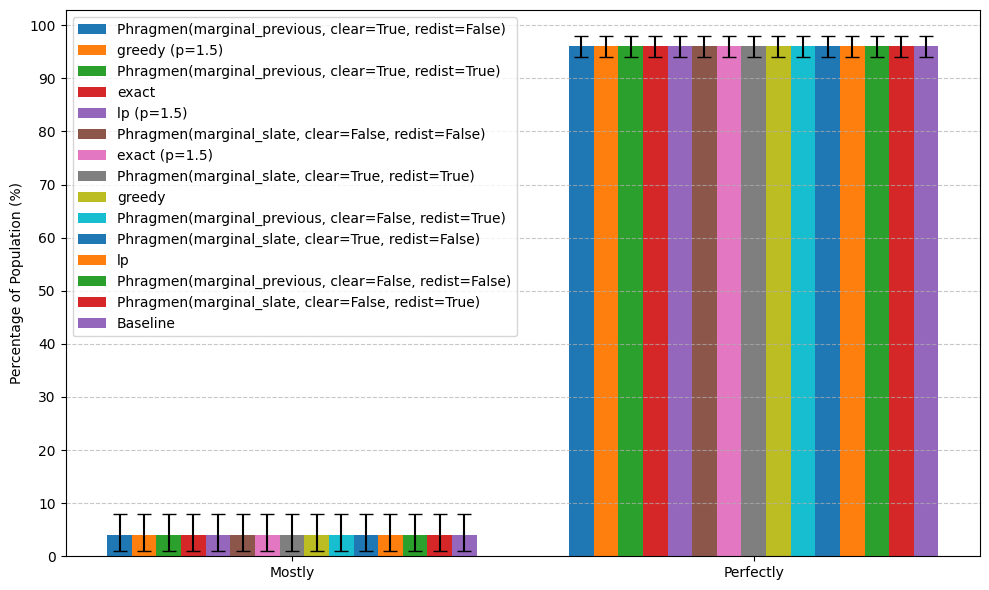

In [16]:
fig = plot_likert_category_clustered_bar_chart(utilities)

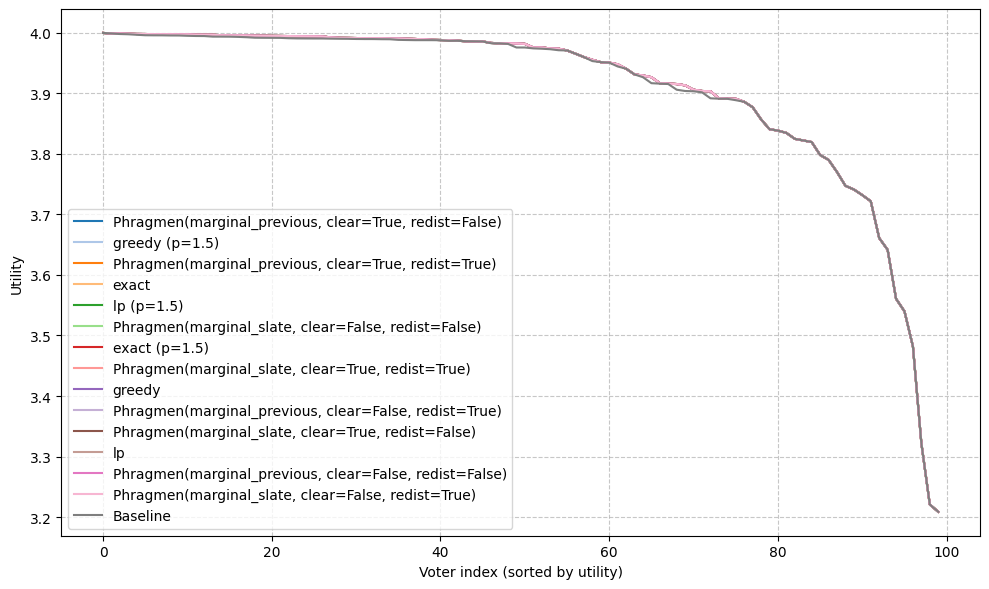

In [17]:
fig = plot_sorted_utility_distributions(utilities)

In [114]:
# embeddings_comparison_fig = plot_sorted_utility_distributions(utilities.loc[:,["Baseline", "Baseline OpenAI Emb."]])

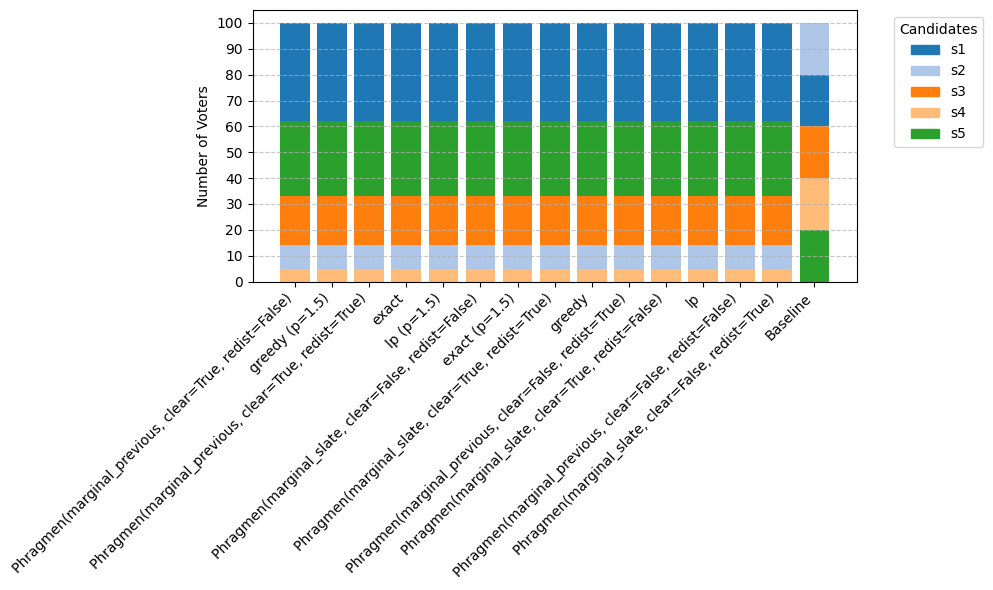

In [18]:
fig = plot_candidate_distribution_stacked(algo_assignments)